# Rectangular regional CESM-MOM6 run to capture the Pacific Cold Tongue

A workflow of utilizing CrocoDash consists of four main steps:

1. Generate a regional MOM6 domain: horizontal grid, bathymetry, vertical grid
2. Create the CESM case: uses visualCaseGen behind the scenes to configure the CESM case with CIME
3. Prepare ocean forcing data: we need tidal data (TXPO), initial fields/tracers (GLORYS), and boundary conditions (GLORYS)
4. Build and run the case: uses scripts in the CESM case, not done within the notebook. 


# SECTION 1: Generate a regional MOM6 domain

We begin by defining a regional MOM6 domain using CrocoDash. To do so, we first generate a horizontal grid. We then generate the topography by remapping an existing bathymetric dataset to our horizontal grid. Finally, we define a vertical grid.

## Step 1.1: Horizontal Grid

This step is very computationally cheap. If you have an existing grid this can also be loaded in.

In [1]:
%load_ext autoreload
%autoreload 2

In [ ]:
from CrocoDash.grid import Grid

grid = Grid(
  resolution = 1/12,
  xstart = 190,
  lenx = 80, # 190°E to 270°E
  ystart = -12.0,
  leny = 24, # 12°S to 12°N
  name = "PacificColdTongue",
)

#

## Step 1.2: Topography

In [3]:
from CrocoDash.topo import Topo

topo = Topo.from_topo_file(
    grid = grid,
    topo_file_path='/glade/work/ajanney/CrocoDash_Input/pacific_archive/ocnice/ocean_topog_PacificColdTongue_d21a8a.nc',
    min_depth = 5,
    )

In [ ]:

bathymetry_path='/glade/work/ajanney/CrocoDashData/inputs/bathymetry/GEBCO_2024.nc'

topo.mpi_interpolate_from_file(
    file_path = bathymetry_path,
    longitude_coordinate_name="lon",
    latitude_coordinate_name="lat",
    vertical_coordinate_name="elevation",
)



            *MANUAL REGRIDDING INSTRUCTIONS*
            
            Calling `mpi_interpolate_from_file` sets up the files necessary for regridding
            the bathymetry using mpirun and ESMF_Regrid. See below for the step-by-step instructions:
            
            1. There should be two files: `bathymetry_original.nc` and `bathymetry_unfinished.nc` located at
            .. 
            
            2. Open a terminal and change to this directory (e.g. `cd .`).
            
            3. Request appropriate computational resources (see example script below), and run the command:
            
            `mpirun -np NUMBER_OF_CPUS ESMF_Regrid -s bathymetry_original.nc -d bathymetry_unfinished.nc -m bilinear --src_var depth --dst_var depth --netcdf4 --src_regional --dst_regional`
            
            4. Run Topo_object.tidy_bathymetry(args) to finish processing the bathymetry. 
            
            Example PBS script using NCAR's Casper Machine: https://gist.github.c

For this example, I am calling the script `/glade/work/ajanney/Pacific_Cold_Tongue_Jofia/process_bathy.sh`. Note: you have to be on a casper login node for this to work. 

My exact steps:
1. SSH to casper login node
2. cd /glade/work/ajanney/Pacific_Cold_Tongue_Jofia
3. qsub process_bathy.sh

In [ ]:
"""
import xarray as xr

bathy_original = xr.open_dataset('/glade/work/ajanney/Pacific_Cold_Tongue_Jofia/bathymetry_original.nc')
bathy_gebco = xr.open_dataset(bathymetry_path)
bathy_original['lon'].attrs = bathy_gebco.lon.attrs

bathy_original.to_netcdf('/glade/work/ajanney/Pacific_Cold_Tongue_Jofia/bathymetry_original_attrs.nc', mode="w", engine="netcdf4")
"""

In [ ]:
"""
bathymetry_regrid = xr.open_dataset('/glade/work/ajanney/Pacific_Cold_Tongue_Jofia/bathymetry_unfinished.nc')

topo.tidy_bathymetry(
    bathymetry=bathymetry_regrid
)
"""

done. Filling in inland lakes and channels... Regridding bathymetry complete. The Topo object now holds the bathymetry information, 
              and it can be modified and visualized using the Topo Editor.


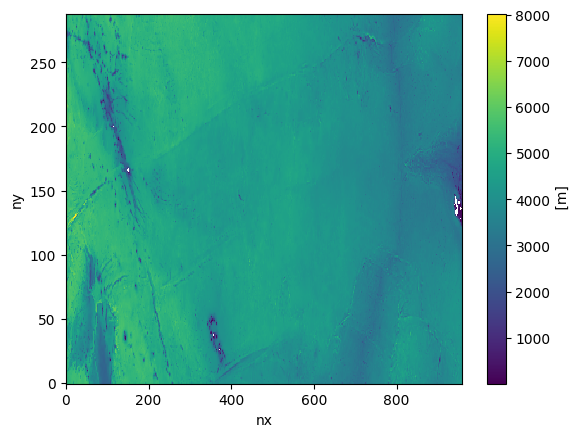

In [4]:
topo.depth.plot()

In [6]:
# Erase Pacific & Canada Bays
%matplotlib ipympl
from CrocoDash.topo_editor import TopoEditor
topo.depth["units"] = "m"
TopoEditor(topo)

TopoEditor(children=(VBox(children=(HTML(value='<h2>Topo Editor</h2>'), HTML(value='<hr><h3>Display</h3>'), To…

## Step 1.3: Vertical Grid

In [7]:
from CrocoDash.vgrid import VGrid

vgrid  = VGrid.hyperbolic(
    nk = 75,
    depth = topo.max_depth,
    ratio=20.0
)

In [8]:
topo.max_depth

8012.750000089288

In [9]:
print(vgrid.dz)

[ 10.53526826  10.60181648  10.68062248  10.77393108  10.88439299
  11.01513608  11.16984833  11.35287403  11.56932482  11.82520717
  12.1275679   12.48465873  12.90612063  13.40318767  13.98890855
  14.67838213  15.48900023  16.44068685  17.55611764  18.86089676
  20.38365943  22.15605884  24.21258525  26.59015476  29.32739692
  32.46356829  36.03702607  40.08321881  44.63219346  49.70568517
  55.31394533  61.45256828  68.09967956  75.21392173  82.7336859
  90.5779598   98.64898639 106.83666667 115.02434695 123.09537354
 130.93964744 138.4594116  145.57365378 152.22076505 158.359388
 163.96764816 169.04113988 173.59011453 177.63630726 181.20976505
 184.34593641 187.08317857 189.46074808 191.5172745  193.2896739
 194.81243657 196.1172157  197.23264649 198.1843331  198.99495121
 199.68442479 200.27014566 200.7672127  201.18867461 201.54576543
 201.84812616 202.10400852 202.3204593  202.503485   202.65819725
 202.78894034 202.89940225 202.99271085 203.07151685 203.13806508]


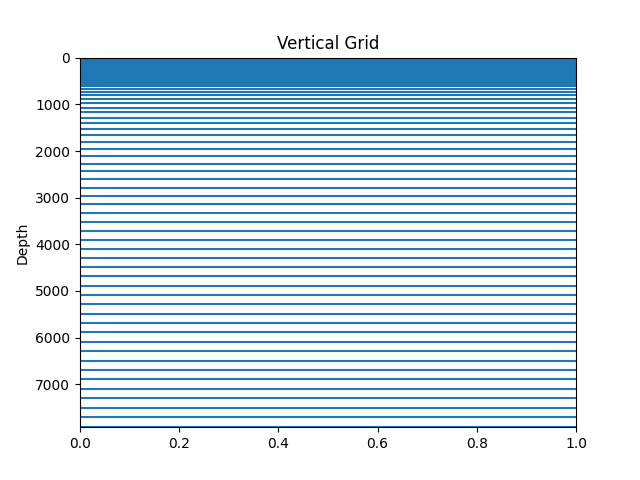

In [12]:
import matplotlib.pyplot as plt
plt.close()
# Create the plot
for depth in vgrid.z:
    plt.axhline(y=depth, linestyle='-')  # Horizontal lines

plt.ylim(max(vgrid.z) + 10, min(vgrid.z) - 10)  # Invert y-axis so deeper values go down
plt.ylabel("Depth")
plt.title("Vertical Grid")
plt.show()

# SECTION 2: Create the CESM case

After generating the MOM6 domain, the next step is to create a CESM case using CrocoDash. This process is straightforward and involves instantiating the CrocoDash Case object. The Case object requires the following inputs:

 - CESM Source Directory: A local path to a compatible CESM source copy.
 - Case Name: A unique name for the CESM case.
 - Input Directory: The directory where all necessary input files will be written.
 - MOM6 Domain Objects: The horizontal grid, topography, and vertical grid created in the previous section.
 - Project ID: (Optional) A project ID, if required by the machine.

## Step 2.1: Specify case name and directories:

Begin by specifying the case name and the necessary directory paths. Ensure the CESM root directory points to your own local copy of CESM. Below is an example setup:

In [13]:
from pathlib import Path

In [ ]:
# CESM case (experiment) name
casename = "pacific_cold_tongue"

# CESM source root (Update this path accordingly!!!)
cesmroot = '/glade/work/ajanney/CESM-versions/CROC_CESM'

# Place where all your input files go 
inputdir = Path("/glade/work/ajanney/CrocoDash_Input",casename) # Path.home() / "croc_input" / casename
    
# CESM case directory
caseroot = Path("/glade/work/ajanney/CESM/cases",casename) # Path.home() / "croc_cases" / casename

## Step 2.2: Create the Case

To create the CESM case, instantiate the `Case` object as shown below. This will automatically set up the CESM case based on the provided inputs: The `cesmroot` argument specifies the path to your local CESM source directory.
The `caseroot` argument defines the directory where the case will be created. CrocoDash will handle all necessary namelist modifications and XML changes to align with the MOM6 domain objects generated earlier.

In [15]:
from CrocoDash.case import Case

case = Case(
    cesmroot = cesmroot,
    caseroot = caseroot,
    inputdir = inputdir,
    ocn_grid = grid,
    ocn_vgrid = vgrid,
    ocn_topo = topo,
    project = 'P93300012',
    override = True,
    machine="derecho"
)

INFO:  csp_solver:CspSolver initialized.


Creating case...

• Updating ccs_config/modelgrid_aliases_nuopc.xml file to include the new resolution "pacific_cold_tongue" consisting of the following component grids.
 atm grid: "TL319", lnd grid: "TL319", ocn grid: "PacificColdTongue".

• Updating ccs_config/component_grids_nuopc.xml file to include newly generated ocean grid "PacificColdTongue" with the following properties:
 nx: 960, ny: 288. ocean mesh: /glade/work/ajanney/CrocoDash_Input/pacific_cold_tongue/ocnice/ESMF_mesh_PacificColdTongue_0565b0.nc.

Running the create_newcase tool with the following command:

/glade/work/ajanney/CESM-versions/CROC_CESM/cime/scripts/create_newcase --compset 1850_DATM%JRA_SLND_SICE_MOM6_SROF_SGLC_SWAV --res pacific_cold_tongue --case /glade/work/ajanney/CESM/cases/pacific_cold_tongue --machine derecho --run-unsupported --project P93300012 --non-local 

The create_newcase command was successful.

Navigating to the case directory:

cd /glade/work/ajanney/CESM/cases/pacific_cold_tongue

Apply NT

INFO:	stage:SUCCESS: All stages are complete.


Case created successfully at /glade/work/ajanney/CESM/cases/pacific_cold_tongue.

To further customize, build, and run the case, navigate to the case directory in your terminal. To create another case, restart the notebook.



# Section 3: Prepare ocean forcing data

We need to cut out our ocean forcing. The package expects an initial condition and one time-dependent segment per non-land boundary. Naming convention is `"east_unprocessed"` for segments and `"ic_unprocessed"` for the initial condition.

In this notebook, we are forcing with the Copernicus Marine "Glorys" reanalysis dataset. There's a function in the `CrocoDash` package, called `configure_forcings`, that generates a bash script to download the correct boundary forcing files for your experiment. First, you will need to create an account with Copernicus, and then call `copernicusmarine login` to set up your login details on your machine. Then you can run the `get_glorys_data.sh` bash script.

## Step 3.1 Configure Initial Conditions and Forcings


In [16]:
case.configure_forcings(
    date_range = ["2020-01-01 00:00:00", "2020-01-05 00:00:00"],
    tidal_constituents = ['M2', 'S2', 'N2', 'K2', 'K1', 'O1', 'P1', 'Q1', 'MM', 'MF'],
    tpxo_elevation_filepath = "/glade/work/ajanney/CrocoDashData/inputs/tidal_data/h_tpxo9.v1.nc",
    tpxo_velocity_filepath = "/glade/work/ajanney/CrocoDashData/inputs/tidal_data/u_tpxo9.v1.nc",
    function_name = "get_glorys_data_from_rda", # way better if working on NCAR machines
    too_much_data = True
)

INFO:CrocoDash.raw_data_access.datasets.glorys:Downloading Glorys data from RDA to /glade/derecho/scratch/ajanney/tmp/tmpuff_xfy5/test_file.nc
INFO:CrocoDash.raw_data_access.datasets.glorys:Downloading Glorys data from RDA to /glade/work/ajanney/CrocoDash_Input/pacific_cold_tongue/glorys/ic_unprocessed.nc


This means that some areas may only have one or two layers between the surface and sea floor. 
For increased stability, consider increasing the minimum depth, or adjusting the vertical coordinate to add more layers near the surface.
Large data workflow was called, please go to the large data workflow path: /glade/work/ajanney/CrocoDash_Input/pacific_cold_tongue/glorys/large_data_workflow and run the driver script there.


In [ ]:
import xarray as xr
temp = xr.open_dataset('/glade/work/ajanney/CrocoDash_Input/pacific_cold_tongue/glorys/ic_unprocessed.nc')
temp.drop_encoding().to_netcdf('/glade/work/ajanney/CrocoDash_Input/pacific_cold_tongue/glorys/ic_unprocessed_clean.nc')

In [ ]:
import xarray as xr
temp = xr.open_dataset('/glade/work/ajanney/CrocoDash_Input/pacific_cold_tongue/glorys/ic_unprocessed.nc')

temp

<xarray.Dataset>
Dimensions:    (time: 1, latitude: 313, longitude: 985, depth: 50)
Coordinates:
  * time       (time) datetime64[ns] 2020-01-01T12:00:00
  * latitude   (latitude) float32 -13.0 -12.92 -12.83 ... 12.83 12.92 13.0
  * longitude  (longitude) float32 -171.0 -170.9 -170.8 ... -89.17 -89.08 -89.0
  * depth      (depth) float32 0.494 1.541 2.646 ... 5.275e+03 5.728e+03
Data variables:
    zos        (time, latitude, longitude) float32 ...
    uo         (time, depth, latitude, longitude) float32 ...
    vo         (time, depth, latitude, longitude) float32 ...
    so         (time, depth, latitude, longitude) float32 ...
    thetao     (time, depth, latitude, longitude) float32 ...
Attributes: (12/24)
    title:              daily mean fields from Global Ocean Physics Analysis ...
    easting:            longitude
    northing:           latitude
    history:            2021/02/17 01:04:46 MERCATOR OCEAN Netcdf creation
    source:             MERCATOR GLORYS12V1
    institution:        MERCATOR OCEAN
    ...                 ...
    longitude_min:      -180.0
    longitude_max:      179.91667
    latitude_min:       -80.0
    latitude_max:       90.0
    z_min:              0.494025
    z_max:              5727.917

## Step 3.2 Run `get_glorys_data.sh`

In a terminal session, locate the `get_glorys_data.sh` script and execute it to download the initial conditions and boundary conditions. Follow the instructions printed by the `configure_forcings` method above.


**TODO:** user copernicusmarine python API within CrocoDash, instead of directing users to run it via CLI. Also, on a derecho login node, both CLI and API fails to run due to the computational demand. We also need to address that.

##  Step 3.3: Process forcing data

In this final step, we call the `process_forcings` method of CrocoDash to cut out and interpolate the initial condition as well as all boundaries. CrocoDash also updates MOM6 runtime parameters and CESM xml variables accordingly.

In [17]:
case.process_forcings()

Large data workflow was called, so boundary conditions will not be processed.
Please make sure to execute large_data_workflow as described in /glade/work/ajanney/CrocoDash_Input/pacific_cold_tongue/glorys/large_data_workflow


INFO:regional_mom6.regridding:Getting t points..
INFO:regional_mom6.regridding:Creating Regridder
INFO:regional_mom6.regridding:Creating Regridder
INFO:regional_mom6.regridding:Creating Regridder


Setting up Initial Conditions
Regridding Velocities... 

INFO:regional_mom6.rotation:Getting rotation angle
INFO:regional_mom6.rotation:Calculating grid rotation angle
INFO:regional_mom6.regridding:Getting u points..
INFO:regional_mom6.regridding:Getting v points..


Done.
Regridding Tracers... Done.
Regridding Free surface... Done.
Saving outputs... done setting up initial condition.


INFO:regional_mom6.regridding:Creating coordinates of the boundary q/u/v points
INFO:regional_mom6.regridding:Creating Regridder


Processing south boundary...

INFO:regional_mom6.regridding:Filling in missing data horizontally, then vertically
INFO:regional_mom6.regridding:Filling in missing data horizontally, then vertically
INFO:regional_mom6.regridding:Adding time dimension
INFO:regional_mom6.regridding:Creating coordinates of the boundary q/u/v points
INFO:regional_mom6.regridding:Adding perpendicular dimension to zamp_segment_001
INFO:regional_mom6.regridding:Adding perpendicular dimension to zphase_segment_001
INFO:regional_mom6.regridding:Generating encoding dictionary
INFO:regional_mom6.regridding:Creating Regridder
INFO:regional_mom6.regridding:Creating Regridder
INFO:regional_mom6.regridding:Filling in missing data horizontally, then vertically
INFO:regional_mom6.regridding:Filling in missing data horizontally, then vertically
INFO:regional_mom6.regridding:Filling in missing data horizontally, then vertically
INFO:regional_mom6.regridding:Filling in missing data horizontally, then vertically
INFO:regional_mom6.rotation:Getting rotat

Done
Processing north boundary...

INFO:regional_mom6.regridding:Filling in missing data horizontally, then vertically
INFO:regional_mom6.regridding:Filling in missing data horizontally, then vertically
INFO:regional_mom6.regridding:Adding time dimension
INFO:regional_mom6.regridding:Creating coordinates of the boundary q/u/v points
INFO:regional_mom6.regridding:Adding perpendicular dimension to zamp_segment_002
INFO:regional_mom6.regridding:Adding perpendicular dimension to zphase_segment_002
INFO:regional_mom6.regridding:Generating encoding dictionary
INFO:regional_mom6.regridding:Creating Regridder
INFO:regional_mom6.regridding:Creating Regridder
INFO:regional_mom6.regridding:Filling in missing data horizontally, then vertically
INFO:regional_mom6.regridding:Filling in missing data horizontally, then vertically
INFO:regional_mom6.regridding:Filling in missing data horizontally, then vertically
INFO:regional_mom6.regridding:Filling in missing data horizontally, then vertically
INFO:regional_mom6.rotation:Getting rotat

Done
Processing west boundary...

INFO:regional_mom6.regridding:Filling in missing data horizontally, then vertically
INFO:regional_mom6.regridding:Filling in missing data horizontally, then vertically
INFO:regional_mom6.regridding:Adding time dimension
INFO:regional_mom6.regridding:Creating coordinates of the boundary q/u/v points
INFO:regional_mom6.regridding:Adding perpendicular dimension to zamp_segment_003
INFO:regional_mom6.regridding:Adding perpendicular dimension to zphase_segment_003
INFO:regional_mom6.regridding:Generating encoding dictionary
INFO:regional_mom6.regridding:Creating Regridder
INFO:regional_mom6.regridding:Creating Regridder
INFO:regional_mom6.regridding:Filling in missing data horizontally, then vertically
INFO:regional_mom6.regridding:Filling in missing data horizontally, then vertically
INFO:regional_mom6.regridding:Filling in missing data horizontally, then vertically
INFO:regional_mom6.regridding:Filling in missing data horizontally, then vertically
INFO:regional_mom6.rotation:Getting rotat

Done
Processing east boundary...

INFO:regional_mom6.regridding:Filling in missing data horizontally, then vertically
INFO:regional_mom6.regridding:Filling in missing data horizontally, then vertically
INFO:regional_mom6.regridding:Adding time dimension
INFO:regional_mom6.regridding:Creating coordinates of the boundary q/u/v points
INFO:regional_mom6.regridding:Adding perpendicular dimension to zamp_segment_004
INFO:regional_mom6.regridding:Adding perpendicular dimension to zphase_segment_004
INFO:regional_mom6.regridding:Generating encoding dictionary
INFO:regional_mom6.regridding:Creating Regridder
INFO:regional_mom6.regridding:Creating Regridder
INFO:regional_mom6.regridding:Filling in missing data horizontally, then vertically
INFO:regional_mom6.regridding:Filling in missing data horizontally, then vertically
INFO:regional_mom6.regridding:Filling in missing data horizontally, then vertically
INFO:regional_mom6.regridding:Filling in missing data horizontally, then vertically
INFO:regional_mom6.rotation:Getting rotat

Done
Adding parameter changes to user_nl_mom:

  ! Initial conditions
  INIT_LAYERS_FROM_Z_FILE = True
  TEMP_SALT_Z_INIT_FILE = init_tracers.nc
  Z_INIT_FILE_PTEMP_VAR = temp
  Z_INIT_ALE_REMAPPING = True
  TEMP_SALT_INIT_VERTICAL_REMAP_ONLY = True
  DEPRESS_INITIAL_SURFACE = True
  SURFACE_HEIGHT_IC_FILE = init_eta.nc
  SURFACE_HEIGHT_IC_VAR = eta_t
  VELOCITY_CONFIG = file
  VELOCITY_FILE = init_vel.nc

  ! Tides
  TIDES = True
  TIDE_M2 = True
  CD_TIDES = 0.0018
  TIDE_USE_EQ_PHASE = True
  TIDE_REF_DATE = 2020, 1, 1
  OBC_TIDE_ADD_EQ_PHASE = True
  OBC_TIDE_N_CONSTITUENTS = 10
  OBC_TIDE_CONSTITUENTS = "M2, S2, N2, K2, K1, O1, P1, Q1, MM, MF"
  OBC_TIDE_REF_DATE = 2020, 1, 1

  ! Open boundary conditions
  OBC_NUMBER_OF_SEGMENTS = 4
  OBC_FREESLIP_VORTICITY = False
  OBC_FREESLIP_STRAIN = False
  OBC_COMPUTED_VORTICITY = True
  OBC_COMPUTED_STRAIN = True
  OBC_ZERO_BIHARMONIC = True
  OBC_TRACER_RESERVOIR_LENGTH_SCALE_OUT = 3.0E+04
  OBC_TRACER_RESERVOIR_LENGTH_SCALE_IN = 3000.0


# Section 4: Build and run the case

After completing the previous steps, you are ready to build and run your CESM case. Begin by navigating to the case root directory specified during the case creation. Before proceeding, review the `user_nl_mom` file located in the case directory. This file contains MOM6 parameter settings that were automatically generated by CrocoDash. Carefully examine these parameters and make any necessary adjustments to fine-tune the model for your specific requirements. While CrocoDash aims to provide a solid starting point, further tuning and adjustments are typically necessary to improve the model for your use case.

Once you have reviewed and modified the parameters as needed, you can build and execute the case using the following commands: 
```
./case.build
./case.submit
```